# 6.6 Cary Time Series

## Contents:

01. Install Libraries
02. Import Libraries
03. Import Datasets
04. Making a Time Series
       - Make Data Subset
       - Create Line Chart of Data
       - Decompose Data Components
       - Conduct Dickey-Fuller Test
       - Stationarize Data
       - Check Auto-Correlations

# 01. Install Libraries

In [2]:
!pip install quandl

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


# 02. Import Libraries

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# 03. Import Datasets

In [8]:
path = r'/home/0668a905-109d-4403-be59-0a04abf51dd9/Cary Real Estate Analysis'

In [11]:
df = pd.read_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', 'cary_grouped.parquet'))

In [14]:
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

# 04. Making a Time Series

### 1. Make Data Subset

##### Selection Notes:

As the Cary property data contained most recent sale dates, I wanted to leverage this information for a time series as it would be the most applicable to the analysis project.

In [201]:
df.head(1)

,location,deedacres,landclass,totalstructures,totalunits,propertydesc,bldgvalue,landvalue,landsalevalue,landsaledate,totalsalevalue,totalsaledate,county,totalbldgsqft,phycity,phyzip,shape_starea,shape_stlength,yearbuilt,geo_shape,geo_point_2d,latitude,longitude,landgroup,calcvalue
0,613 Hanson Rd,0.15,Res 1 Family,NaN,NaN,BAY POINTE/PH:03/LT#099 PL000161-000365,195234,40180,40180,NaT,235414,2017-10-27,Durham,2080,Durham,27713,6451.097435,336.681551,NaT,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,b'\x01\x01\x00\x00\x00;\x87\xfc\xe6~\xbaS\xc09...,35.941222,-78.913996,Residential,235414


In [203]:
df.shape

(278468, 25)

In [205]:
# Ensure 'totalsaledate' is in datetime 
df['totalsaledate'] = pd.to_datetime(df['totalsaledate'])
df['totalsaledate'].dtypes

dtype('<M8[ns]')

In [207]:
# Creating subset for conditions of only totalsaledate with values (no missing dates), totalsalevalue greater than $1, and landgroup filtered down to "residential"
sale_sub = df[df['totalsaledate'].notnull() & (df['totalsalevalue'] > 1) & (df['landgroup'] == 'Residential')][['totalsaledate', 'totalsalevalue']]
sale_sub.shape

(207265, 2)

In [209]:
# Set 'totalsaledate' as the index
sale_sub.set_index('totalsaledate', inplace=True)

In [211]:
sale_sub.head()

,totalsalevalue
totalsaledate,
2017-10-27,235414
2023-12-05,220192
2013-06-27,221064
2023-10-26,231169
2017-12-28,202374


In [222]:
# Aggregate sales by date
daily_sales = sale_sub.resample('D')['totalsalevalue'].sum()

### 2. Create Line Chart of Data

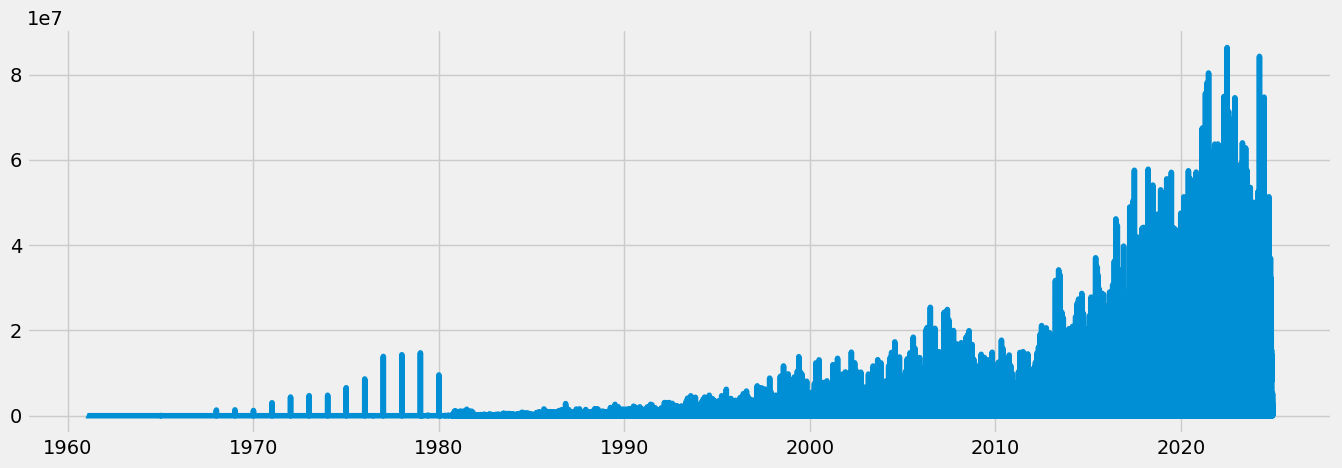

In [224]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(daily_sales)

##### Notes: Lots of information here! Need to filter down by year and landgroup type

In [226]:
# Reset index so that you can use the "Date" column as a filter
property_sales_2 = daily_sales.reset_index()

In [283]:
property_sales_2.head(1)

,totalsaledate,totalsalevalue
0,1961-01-01,14900


In [272]:
year_sub = property_sales_2.loc[(property_sales_2['totalsaledate'] >= '1990-01-01') & (property_sales_2['totalsaledate'] < '2024-12-01')]
year_sub.head(5)

,totalsaledate,totalsalevalue
10592,1990-01-01,0
10593,1990-01-02,80000
10594,1990-01-03,137000
10595,1990-01-04,395000
10596,1990-01-05,330000


In [275]:
# Reset totalsaledate as index

from datetime import datetime

year_sub['datetime'] = pd.to_datetime(year_sub['totalsaledate']) 
year_sub = year_sub.set_index('datetime') 
year_sub.drop(['totalsaledate'], axis=1, inplace=True)
year_sub.head()

,totalsalevalue
datetime,
1990-01-01,0
1990-01-02,80000
1990-01-03,137000
1990-01-04,395000
1990-01-05,330000


In [292]:
# Aggregate sales by date
quarterly_sales = year_sub.resample('Q')['totalsalevalue'].sum()

In [375]:
quarterly_sales.tail(20)

datetime
2020-03-31    1.175823e+09
2020-06-30    1.448264e+09
2020-09-30    1.766875e+09
2020-12-31    1.708705e+09
2021-03-31    1.457137e+09
2021-06-30    2.198496e+09
2021-09-30    2.032031e+09
2021-12-31    1.998469e+09
2022-03-31    1.654301e+09
2022-06-30    2.295880e+09
2022-09-30    1.981833e+09
2022-12-31    1.638142e+09
2023-03-31    1.402091e+09
2023-06-30    1.815720e+09
2023-09-30    1.683011e+09
2023-12-31    1.469124e+09
2024-03-31    1.376139e+09
2024-06-30    2.064475e+09
2024-09-30    1.563975e+09
2024-12-31    7.637014e+08
Freq: Q-DEC, Name: totalsalevalue, dtype: float64

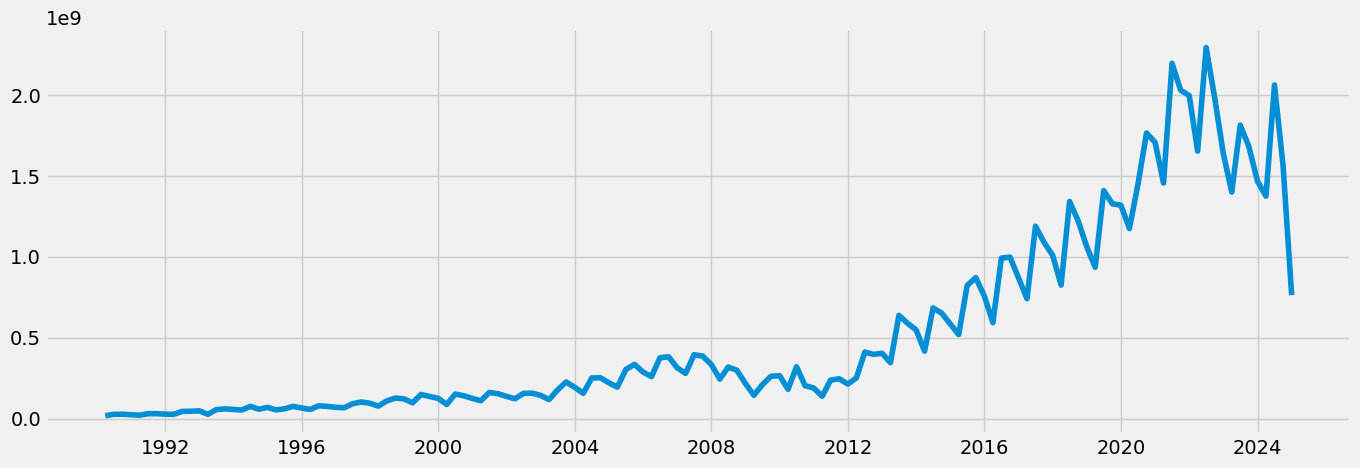

In [294]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(quarterly_sales)

##### Subset Notes:

1. Years 1990 through 2024 were selected as previous year's data was more inconsistent with less property sale dates accounted for. Could there be a lack of data collection during that time period? Even 2000 - 2024 might be more relevant, but will stick with testing 1990 - recent for now.

2. Using subset of "Residential" properties for the time series. This helped bring down some of the outliers of non-residential property sales.

3. Aggregated the totalsalevalues by Quarter. Day & Month aggregates were too chaotic and noisy.

### 3. Decompose Data Components

In [300]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(quarterly_sales, model='additive')

In [303]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

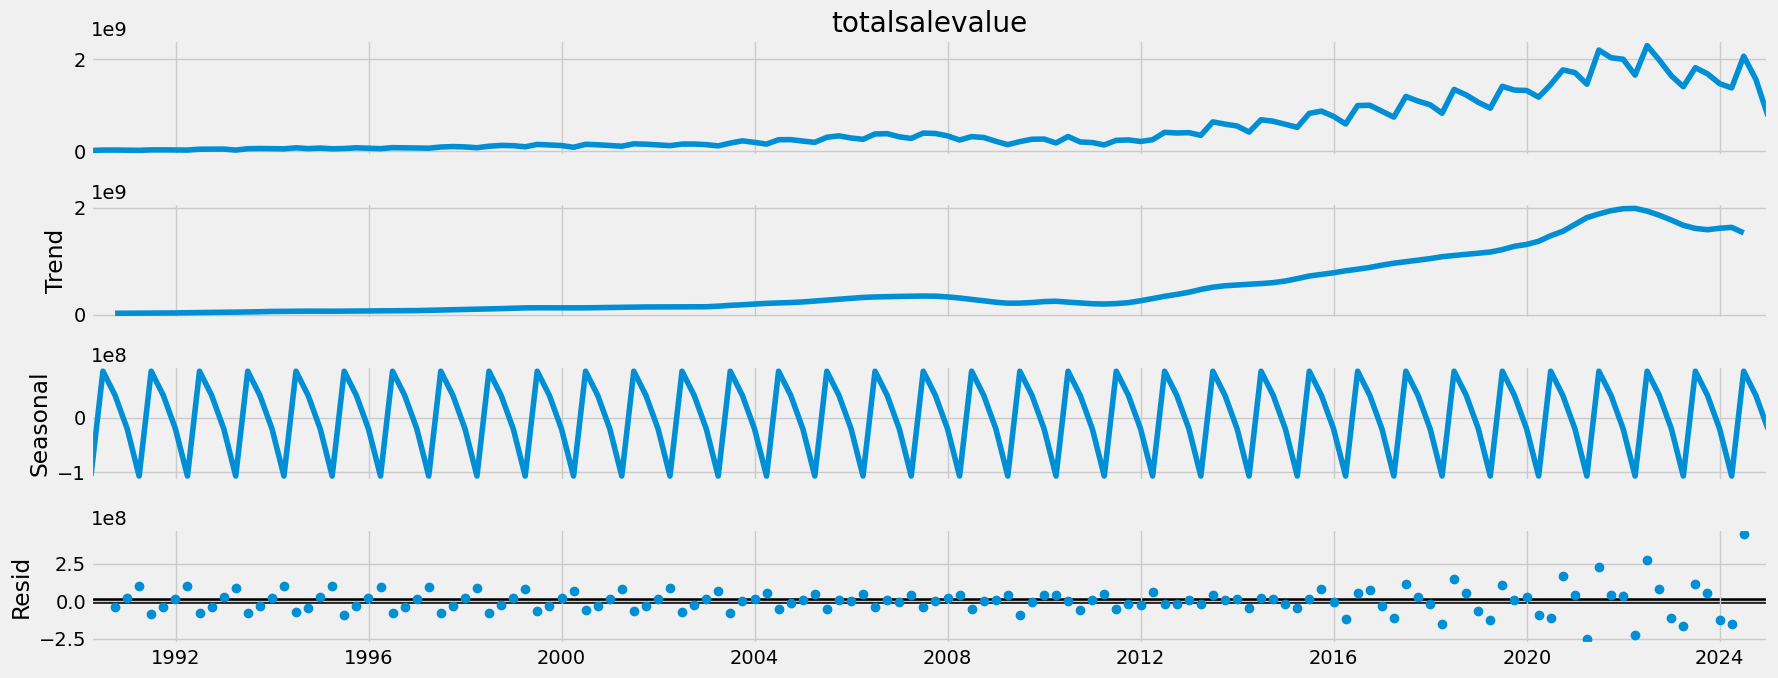

In [306]:
# Plot the separate components

decomposition.plot()
plt.show()

##### Notes on Decomposition:

1. Top line is data line chart with all components.

2. Second line represents the underlying, dominant trend. It's steady through the 90s, early 2000s, and then steadily increases until it hits a peak in around 2022.

3. Third line represents (summer sales higher than winter?).

4. Fourth line represents noise or 'residual' data. It's somewhat consistent until about 2016 and data points becomre more distanced.

### 4. Conduct Dickey-Fuller Test

In [326]:
quarterly_sales = quarterly_sales.astype(float)

In [380]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(quarterly_sales)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.500597
p-value                          0.007972
Number of Lags Used             12.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


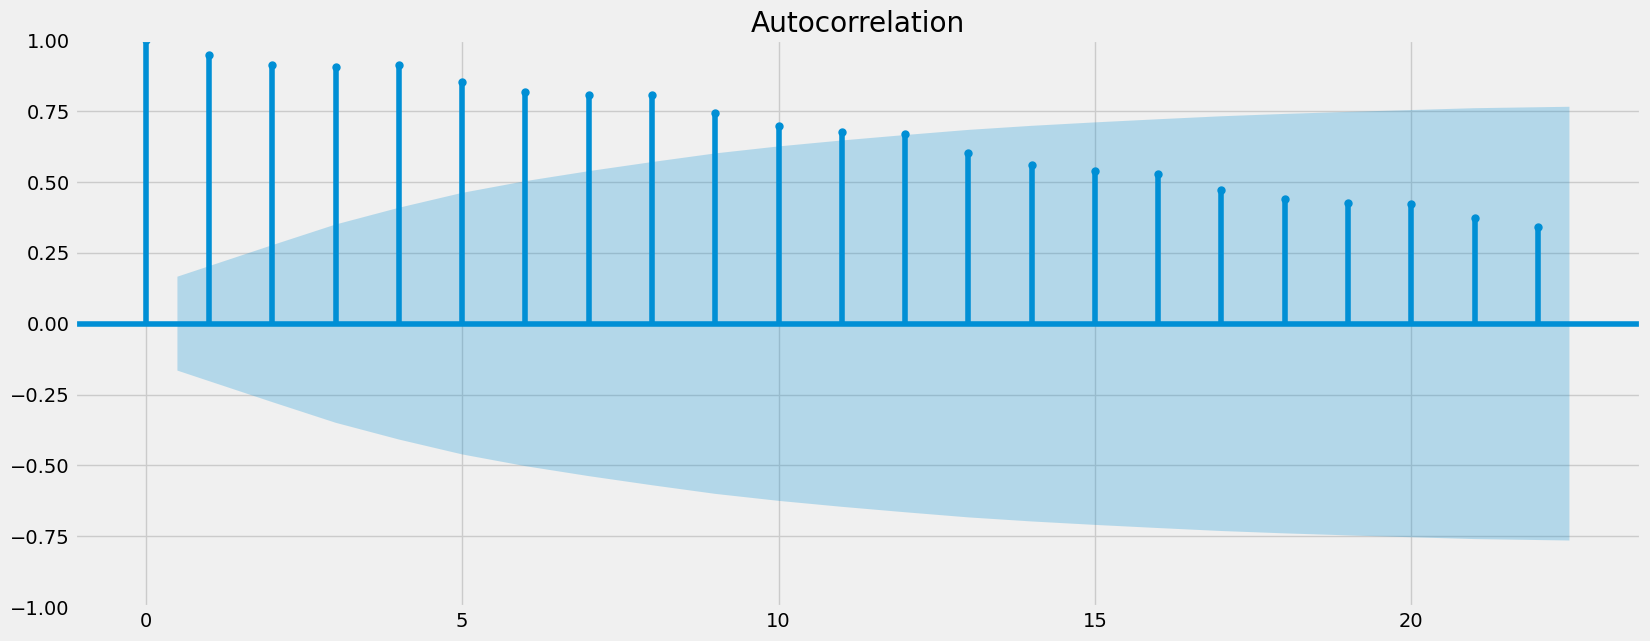

In [382]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(quarterly_sales)
plt.show()

##### Notes on Test:

1. The goal of the null hypothesis for the Dickey-Full test is to disprove a unit root, meaning that the data would need to be stationary in order to disprove.

2. Based on my P-value of 0.007972 being less than 5%, and my test value of -3.500597 being less than even the 1% confidence value, I would assume that the null hypothesis could be rejected, and that my data is stationary.

3. When looking at the autocorrelation, there are still lines outside of the confidence interval zone--does this mean data is not stationary? Will try differencing to see what the outlook is.

### 5. Stationarize Data

In [337]:
data_diff = quarterly_sales - quarterly_sales.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [340]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [343]:
data_diff.head()

datetime
1990-06-30    8562500.0
1990-09-30     828000.0
1990-12-31   -3174882.0
1991-03-31   -3065618.0
1991-06-30    9257250.0
Freq: Q-DEC, Name: totalsalevalue, dtype: float64

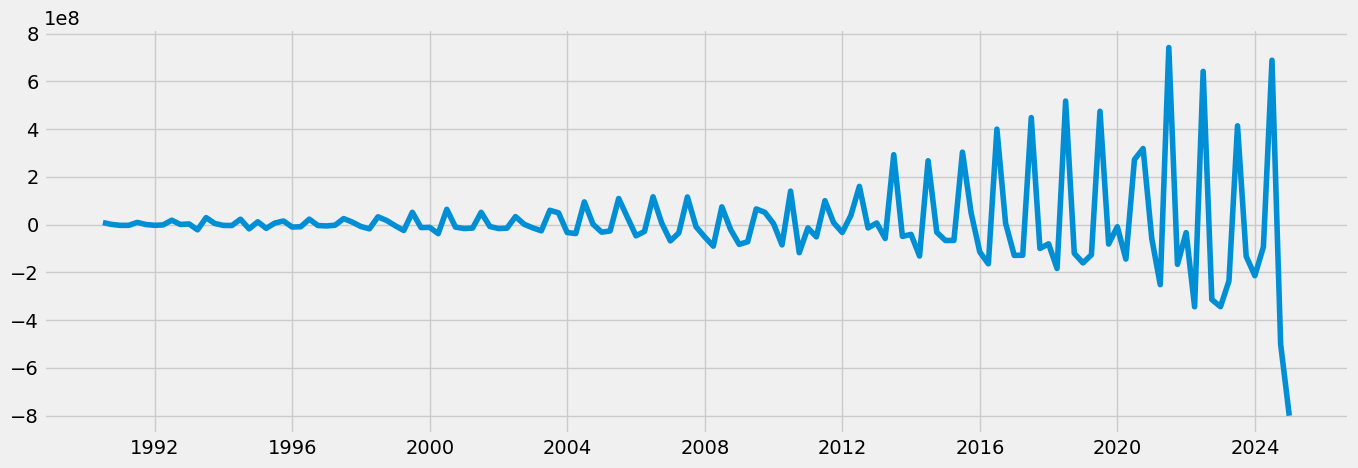

In [350]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

#### Repeat Dickey-Fuller

In [356]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.706501
p-value                          0.427766
Number of Lags Used             14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


### 6. Check Auto-Correlations

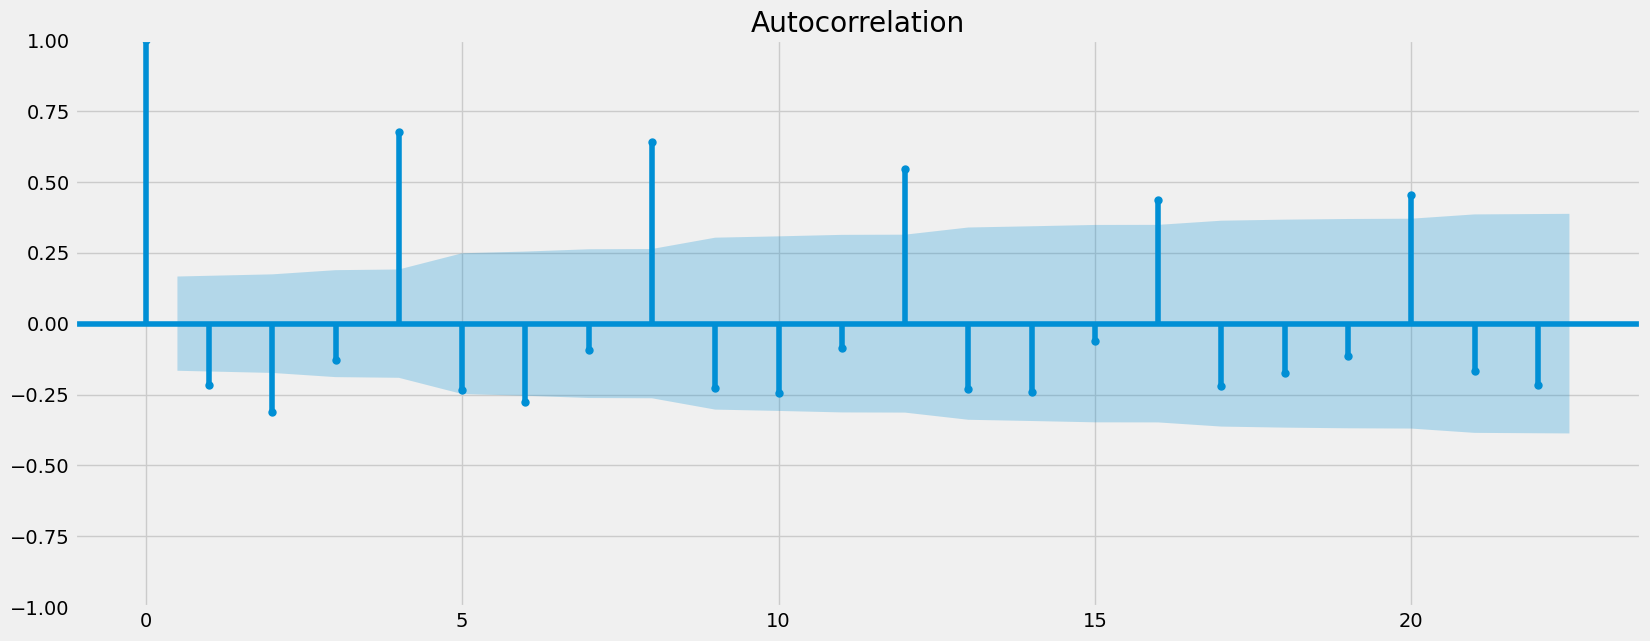

In [359]:
plot_acf(data_diff)
plt.show()

##### Differencing Notes:

Now the Dickey-Fuller results show that my test value is great than the critical values, and the autocorrelation looks odd / has lines outside of the confidence internal.